## 0)  MLFM PVLIB 
##### ver:220627
#### Steve Ransome (SRCL) and Juergen Sutterlueti (Gantner Instruments)  
##### Additions from Cliff Hansen (Sandia)

## Tutorial overview.

I) The Loss Factors Model (LFM) |2011 ref 1| quantifies  
normalised losses from module parameters  
(e.g. i_sc, r_sc, i_mp, v_mp, r_oc and v_oc) by analysing the shape  
of the IV curve and comparing it with STC reference values from the datasheet.  

II) The Mechanistic performance model (MPM) |2017 ref 2|  
has "meaningful,independent, robust and normalised" coefficients  
which fit how the LFM values depend on irradiance, module temperature  
(and windspeed) and time.  
  
These parameters relate to  
    - c_1 = "overall performance quality"  
    - c_2 = "normalised temperature coefficient" (units /K)  
    - c_3 = "low light level drop" due to v_oc and r_sc (r_shunt)  
    - c_4 = "high light level fall" due to r_oc (~Rseries).  
    (optional)  
    - c_5 = "wind speed coefficient"  
    - c_6 = "low light level drop" sometimes needed for r_shunt behaviour.  

III) This tutorial shows how to take module measured and weather data,  
(either outdoor or IEC 61853-like   
matrix data), normalise it, generate MLFM coefficients, fit them with the MPM then  
analyse module performance looking for loss values, degradation and  
allowing performance predictions.   

![mlfm_data/figs/mlfm_flow.png](mlfm_data/figs/mlfm_flow.png)  

Fig 1: MLFM overview flow chart of this tutorial.   

In [40]:
#import pvlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# FIND AND SHOW INSTALLATION CURRENT WORKING DIRECTORY
import os
root_dir = os.getcwd()

root_dir

# Import essential library file with lfm and mpm definitions
from pvlib.mlfm import mlfm_meas_to_norm, mlfm_6, mlfm_norm_to_stack, mlfm_fit
# Import graphics code 
from pvlib.mlfm import plot_mlfm_scatter, plot_mlfm_stack 

# STANDARD DEFINITIONS

# https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.rcParams['figure.figsize'] = [7,5]  # setup figure size inches
plt.rcParams.update({'font.size': 12})  # setup fontsize
plt.linewidth = 1.5                     # line width in points
plt.linestyle = '--' #-                 # solid line
plt.marker = 's' #o                     # the default marker
plt.markersize = 9 #6                   # marker size, in points
plt.bbox = 1.4                          # offset right to not overwrite

## 1) Select MLFM measurement 

Three default files are included (* = version number )  

(0) g78_T16_Xall_F10m_R900*.csv  
(1) n05667_Y13_R1k6_fClear*.csv  
(2) x19074001_iec61853*.csv      

Essential default column names in meas() are :-  

meas {  
'date_time', 'module_id',  
'poa_global', 'wind_speed', 'temp_air', 'temp_module',   
'v_oc', 'i_sc', 'i_mp', 'v_mp',  
'r_sc', 'r_oc'  <-- optional  
}


File naming conventions can be used to help identify files, for example  
`x81_T1906_D3_Fh.csv`  

where   
   - x = source e.g. (G)antner, (N)rel, (S)andia, matri(X), ...  
   - 81 = module id/channel number                               
   - T1906 = (T)ime started = yymm(dd)                      
   - D3 = (D)uration in days                             
   - Fh = (F)requency e.g. (h)ours  or (10m)10 minutes      
   - etc.   

In [41]:
# select one of the following meas files

# mlfm_meas_file = 'g78_T16_Xall_F10m_R900_041.csv'  
#   File contains: 
#   - date_time, module_id, 
#   - poa_global (W/m2)
#   - wind_speed (m/s)
#   - temp_air (C)
#   - blue_frac
#   - beam_frac
#   - temp_module (C) 
#   6 measured IV curve quantities
#   - v_oc, i_sc, i_mp, v_mp, 
#   - r_sc, r_oc

mlfm_meas_file = 'n05667_Y13_R1k6_fClear_041.csv'  
#   File contains: 
#   - date_time, module_id, 
#   - poa_global (W/m2)
#   - wind_speed - all zeros (m/s)
#   - temp_air (C)
#   - temp_module (C) 
#   - unused environmental quantities: relative_humidity, precipitation, dni, ghi, dhi, soil
#   4 measured IV curve quantities
#   - v_oc, i_sc, i_mp, v_mp, 
#   - unused IV curve quantities: p_mp, ff
    
# mlfm_meas_file = 'x19074001_iec61853_041.csv'      
#   File contains: 
#   - date_time : integers in this file
#   - module_id, 
#   - temp_module (C) 
#   - poa_global (W/m2)
#   - wind_speed - all zeros (m/s)
# - 4 measured IV curve quantities
#   - v_oc, i_sc, i_mp, v_mp, 
#   - unused IV curve quantities: p_mp
    
# extract module id from filename e.g. 'g78'
mlfm_mod = mlfm_meas_file.split('_')

mlfm_mod_sel = mlfm_mod[0]

## 2) Get ref module data at STC  

Get STC Reference module data for the selected module  
(searching for a row with same module id).  
  
Ref values include electrical data and temperature coeffs and must include the following :-  

ref {  
'i_sc', 'i_mp', 'v_mp', 'v_oc',   
'alpha_i_sc', 'alpha_i_mp', 'beta_v_mp', 'beta_v_oc', 'gamma_p_mp', 
}  

NOTE : Users must add their own data to the reference file  
when they add new meas data. 


If alpha_i_mp and beta_v_mp are not known  
use the following approximations :-  
    alpha_i_mp = 0  
    beta_v_mp = gamma_p_mp  


### Read all reference module data 

In [42]:
# user must keep updated with their modules from their measurements
ref_file_name = (root_dir + '\\mlfm_data\\ref\\' + 'mlfm_reference_modules.csv')

ref_data = pd.read_csv(ref_file_name, index_col='module_id')

## 3) Select module stc data from reference database

In [43]:
while True:
    try:
        ref_data = ref_data[ref_data.index == mlfm_mod_sel]
        break

    except IndexError:
        print("You must define module ref data to use this module ...")
        break

In [44]:
# Put relevant data into a dict for easy use
# ignore any other columns that may be database specific
# as they aren't needed

ref = dict(
    # module_id  =  ref_data['index'].values[0],
    i_sc = ref_data['i_sc'].values[0],
    i_mp = ref_data['i_mp'].values[0],
    v_mp = ref_data['v_mp'].values[0],
    v_oc = ref_data['v_oc'].values[0],

    alpha_i_sc = ref_data['alpha_i_sc'].values[0],
    beta_v_oc = ref_data['beta_v_oc'].values[0],
    alpha_i_mp = ref_data['alpha_i_mp'].values[0],
    beta_v_mp = ref_data['beta_v_mp'].values[0],
    gamma_pdc = ref_data['gamma_pdc'].values[0],
)

# create p_mp and ff in case they don't exist
ref['p_mp'] = ref['i_mp'] * ref['v_mp']

ref['ff'] = ref['p_mp'] / (ref['i_sc'] * ref['v_oc'])

## 4) Import measured data (outdoor or matrix)

DateTime, Met and Raw module measurements.  

## 5) Read in selected measured file data 

In [45]:
meas = pd.read_csv(
    root_dir + '\\mlfm_data\\meas_gtw\\' + mlfm_meas_file,
    index_col='date_time'
)

## 6) Calculate useful data columns for meas

In [46]:
# normalise poa_global to kW/m^2
meas['poa_global_kwm2'] = meas['poa_global'] / 1000

# calculate p_mp as it might be missing
meas['p_mp'] = meas['i_mp'] * meas['v_mp']

#show some meas data
meas.head(3)

,module_id,poa_global,temp_module,i_sc,p_mp,i_mp,v_mp,v_oc,ff,temp_air,relative_humidity,pressure,precipitation,dni,ghi,dhi,soil,wind_speed,poa_global_kwm2
date_time,,,,,,,,,,,,,,,,,,,
2013-01-04 08:05:12-06:00,n05667,24.0,4.7,0.1361,4.869814,0.1255,38.8033,45.8512,78.01,4.9,82.2,1007.1,0,0.0,18.1,18.3,1.0,0,0.0240
2013-01-04 08:10:12-06:00,n05667,33.0,5.2,0.1788,6.530535,0.1657,39.4118,46.4089,78.72,5.0,82.9,1007.0,0,1.6,24.9,25.0,1.0,0,0.0330
2013-01-04 08:15:12-06:00,n05667,204.7,6.5,1.1024,45.349227,1.0548,42.9932,50.0780,82.15,5.2,81.9,1007.1,0,353.4,53.0,31.5,1.0,0,0.2047


## 7) Count how many independent mlfm variables are in the data  
usually matrix=4 (i_sc, i_mp, v_mp, v_oc)  
and iv=6 (i_sc, i_mp, v_mp, v_oc + r_sc, r_oc) 

In [47]:
def get_qty_mlfm_vars(dmeas):
    '''
    Find the quantity of MLFM variables in the measured data
    (e.g. I_MP+V_MP=2, MATRIX=4, IV_CURVE=6).
    
    Parameters
    ----------
    dmeas : dataframe
        measured weather data
        'poa_global', 'temp_module', 'wind_speed'
        and measured electrical/thermal values
        'i_sc' .. 'v_oc', temp_module.
    
    Returns
    -------
    qty_mlfm_vars : int
        number of mlfm_values present in data usually
        2 = (imp, vmp) from mpp tracker
        4 = (i_sc, i_mp, v_mp, v_oc) from matrix
        6 = (i_sc, i_mp, v_mp, v_oc, r_sc, r_oc) from iv curve.
    '''
    # find how many mlfm variables were measured
    qty_mlfm_vars = 0
    for mlfm_sel in ('i_sc', 'r_sc', 'i_mp', 'v_mp', 'r_oc', 'v_oc'):
        if mlfm_sel in dmeas.columns:
            qty_mlfm_vars += 1
            #print(qty_mlfm_vars, mlfm_sel)
    
    return qty_mlfm_vars

In [48]:
qty_mlfm_vars = get_qty_mlfm_vars(meas)

qty_mlfm_vars

4

## 8) Normalise MLFM values norm from meas and ref dataframes  

Fig 2 illustrates the loss factors model (LFM).  
It uses the shape and values from dc measurements to quantify the values of each  
of the loss factors going from (1) ref_p_mp to (5) meas_p_mp.  

![mlfm_data/figs/mlfm_iv.png](mlfm_data/figs/mlfm_iv.png)  

Fig 2: Loss Factors Model :  

1) ref_p_mp = Initial datasheet value at STC.

2) Multiply by 1/FF to get to (ref_i_sc * ref_v_oc) to start to analyse current and voltage losses  

3) Three 'current' losses get from ref_i_sc to norm_i_mp
   - norm_i_sc = measured / expected isc (purple)
   - norm_r_sc = loss caused by 'shunt resistance' slope at i_sc (orange)
   - norm_i_ff = loss caused by 'current part' of fill factor (green).  
    
    
4) Three 'voltage' losses (plus a temperature coefficient) get from from ref_v_oc to norm_v_mp     
   - norm_v_ff = loss caused by 'voltage part' of fill factor (blue)
   - norm_r_oc = loss caused by 'series resistance' slope at v_oc (pink)
   - norm_v_oc_t = measured / expected v_oc temp_corrected (brown)
   - norm_temp_corr = optional temp correction subtracted from v_oc (red).    
    
    
5) These losses cause the performance to fall to pr_dc = meas_p_mp / ref_p_mp  

pr_dc = 1/ff *                                    
    (norm_i_sc * norm_r_sc * norm_i_ff ) *             
    (norm_v_ffv * norm_r_oc * norm_v_oc_t * norm_temp_corr )   

Note:  
The gamma temperature correction is subtracted from voc for simplicity.  
In reality there will be temperature dependencies for i_sc and ff but they are smaller.

In [49]:
norm = mlfm_meas_to_norm(meas, ref) ##SR##, qty_mlfm_vars)

# show some normalised data
norm.head(3)

,pr_dc,pr_dc_temp_corr,i_sc,i_mp,v_oc,v_mp,v_oc_temp_corr
date_time,,,,,,,
2013-01-04 08:05:12-06:00,0.956856,0.889529,1.039376,0.922116,0.915011,0.846288,0.865476
2013-01-04 08:10:12-06:00,0.933212,0.869166,0.993069,0.926734,0.926140,0.849229,0.877238
2013-01-04 08:15:12-06:00,1.044714,0.977723,0.987068,0.956821,0.999361,0.858525,0.950057


## 9) Make irradiance and temperature bins for pivot tables 
(Gbin=100W/m^2, Tbin=5C)

In [50]:
# poa_global bin e.g. 100, 200 .. 1100W/m2
norm['poa_global_bin'] = meas['poa_global'].round(-2)

# temp_module bin e.g. 5, 10 .. 75C
norm['temp_module_bin'] = (5 * round(meas['temp_module'] / 5,0))

## 10) Perform sanity checks on meas and norm data  

It's easier to sanity check and study normalised data than raw values.  
1) Remove bad, missing, unwanted  or outlier data  
2) User defined limits may depend on data scatter and degradation   
3) Can either select on values e.g. '0.5 <pr_dc < 1.5' or on '>x stdev from mean'  
4) Possible to select on dates if desired.  

In [51]:
# select by irradiance poa_global range e.g. 100-1100W/m2
meas = meas[(meas['poa_global'] >= 100) &
            (meas['poa_global'] <= 1100)]

# if there's date_time can select by it, i.e. not matrix data
### better if index is formatted as a date

# if qty_mlfm_vars == 6:

    # not for matrix as they don't contain dates
    # example
    # meas = meas[(meas.index > '2016-01-01') &
    #        (meas.index < '2017-01-01')]


In [52]:
# remove specific mlfm values outside limits e.g. <0.5 or >1.5
norm = norm[((norm['pr_dc'] > 0.5) & 
             (norm['pr_dc'] < 1.5))]

# remove all mlfm values outside x~3 stdevs
if qty_mlfm_vars == 6:
    # only needed for outdoor data as indoor ought to be less scattered
    # remove all mlfm data > x stdev usually 3
    stdevs = 3

    for lfm in ('i_sc', 'r_sc', 'i_ff', 'v_ff', 'r_oc','v_oc'):
        norm = norm[
            ((norm[lfm] - norm[lfm].mean()) /
                 norm[lfm].std()).abs() < stdevs
        ]

## 11) Filter only matching rows from meas and norm data
like an inner join but leave data in separate norm and meas frames

In [53]:
#drop meas rows that aren't in norm
meas_not_in_norm = ~meas.index.isin(norm.index)
meas = meas.drop(meas[meas_not_in_norm].index)

#drop norm rows that aren't in meas
norm_not_in_meas = ~norm.index.isin(meas.index)
norm = norm.drop(norm[norm_not_in_meas].index)

## 12) Plot normalised MLFM data vs irradiance  

For outdoor data -  
LFM values norm() should be narrow, smooth lines (around 70-120% on the yaxis).

For matrix data -  
LFM values norm() should be close, almost parallel lines (around 70-120% on the yaxis).

1. Higher values are always better (unlike measured values such as  
    Rseries or Io where lower is better)
1. Accurate measurements and a stable module result in narrowest lines  
1. v_oc and r_sc tend to fall at low light levels ( / left)  
1. r_oc tends to fall at high light levels ( \ right)  
1. i_ff and v_ff are usually fairly flat ( - ) 
1. i_sc may vary the most due to spectral sensitivity, soiling, shading  
    and/or snow (if not properly corrected).    

## 13) : Normalised mlfm values vs. irradiance. Fig 3.

All traces should be thin, usually around 0.9 ± 0.1  
i_sc may be more scattered if there is uncorrected soiling, spectral and angle of incidence ###

In [54]:
meas.head()

,module_id,poa_global,temp_module,i_sc,p_mp,i_mp,v_mp,v_oc,ff,temp_air,relative_humidity,pressure,precipitation,dni,ghi,dhi,soil,wind_speed,poa_global_kwm2
date_time,,,,,,,,,,,,,,,,,,,
2013-01-04 08:15:12-06:00,n05667,204.7,6.5,1.1024,45.349227,1.0548,42.9932,50.0780,82.15,5.2,81.9,1007.1,0,353.4,53.0,31.5,1.0,0,0.2047
2013-01-04 08:20:12-06:00,n05667,238.0,8.4,1.2937,52.964895,1.2344,42.9074,50.0932,81.73,5.3,80.8,1007.2,0,395.1,65.2,36.7,1.0,0,0.2380
2013-01-04 08:25:12-06:00,n05667,272.4,10.3,1.4898,60.822567,1.4194,42.8509,50.1119,81.47,5.6,79.7,1007.3,0,435.6,78.2,41.6,1.0,0,0.2724
2013-01-04 08:30:12-06:00,n05667,209.1,10.7,1.1510,46.371708,1.0956,42.3254,49.4631,81.46,5.9,78.9,1007.2,0,284.3,72.2,44.9,1.0,0,0.2091
2013-01-04 08:35:12-06:00,n05667,204.3,10.7,1.1235,45.179177,1.0680,42.3026,49.4346,81.34,5.7,78.6,1007.2,0,264.6,75.5,47.3,1.0,0,0.2043


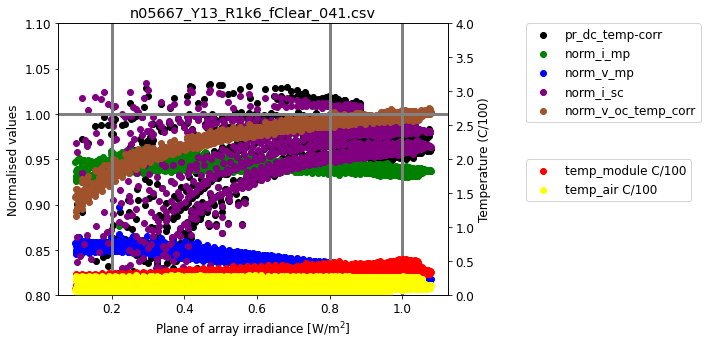

In [55]:
# scatter plot normalised values vs. irradiance
fig_scatter = plot_mlfm_scatter(meas, norm, mlfm_meas_file) ##SR##, qty_mlfm_vars) add scatter


Fig 3 : MLFM multiplicative factors vs. irradiance


## 14) Convert multiplicative to subtractive losses to show on a stack plot  

LFM losses can be analysed as either    

- multiplicative    
pr_dc = 1/ff * ( norm(i_sc) * norm(r_sc) * norm(i_ff) * 
        norm(v_ff) * norm(r_oc) * norm(v_oc_t) * norm(temp_corr) ).  
 
   
  
-  subtractive  
pr_dc = 1/ff -   (stack(i_sc) + stack(r_sc) + stack(i_ff) -  
        stack(v_ff) + stack(r_oc) + stack(v_oc_t) + stack(temp_corr) ). 
  
Multiplicative losses are easier to understand but to represent them on a graph  
it's easier to show them as a stacked plot where the values are 'translated'  
so the sum of the stacked losses is shown to equate to the product of the  
multiplicative losses.

In [56]:
# translate multiplicative to stack losses and add to dataframe
stack = mlfm_norm_to_stack(norm, fill_factor = ref['ff'])

# show some stack losses
stack.head(3)

,pr_dc,i_sc,i_mp,i_v,v_mp,v_oc,temp_module_corr
date_time,,,,,,,
2013-01-04 08:15:12-06:00,1.044714,0.015955,0.048271,0.01,0.169543,0.000788,-0.060828
2013-01-04 08:20:12-06:00,1.049437,0.004612,0.051860,0.01,0.172945,0.000416,-0.054896
2013-01-04 08:25:12-06:00,1.052938,-0.003006,0.053871,0.01,0.175514,-0.000047,-0.048840


## 15) Plot stack losses vs. measurement  

Fig 4 Shows how to quantify losses by loss parameters stack(i_sc, .. v_oc).  

![stack5D_0_4.png](mlfm_data/figs/mlfm_stack.png)  

Fig 4 Stacked losses by measurement  

- It plots them in a stacked format from the lossless limit 1/ff (top)  
  subtracting each loss value in turn until it reaches pr_dc (bottom).  
  
- This figure shows a typical c-Si module for four clear days for  
  different months July to Oct in AZ.   
  
- In the middle of the days the high irradiance results in the biggest  
  losses being due to r_oc (red, ~rseries, pink) and temp_module  
  (as the module heats to 60C).   
  
- Early mornings/late afternoons there is a slight Isc gain (purple,  
  top, due to spectral mismatch) but an Isc loss mid day due to soiling.  

Stack losses are indicated by their colours  
(from top to bottom for mlfm4=matrix and mlfm6=ivcurve)   

`+-----+----+-------+--------+------------+--------------+`  
`|  1  | 2  |   4   |   6    | <qty_mlfm  |              |`  
`|     |mpp | matrix|iv_curve| colours    |    comments  |`  
`| 1/FF+----+-------+--------+------------+--------------+`  
`| v   |    | (i_sc)| (i_sc) | (purple)   | (optional)   |`  
`| v   |    |- - - -|- - - - |- - - - - - |- - - - - - - |`  
`| v   |    |       |  r_sc  | orange     |  current     |`  
`| v   |    +       +--------+------------+              |`  
`| v   |i_mp|  i_mp |  i_ff  | green      |  losses      |`  
`|-v---|----+-------+--------+-black------+--------------+`   
`| v   |v_mp|  v_mp |  v_ff  | blue       |  voltage     |`  
`| v   |    +       +--------+------------+              |`  
`| v   |    |       |  r_oc  | pink       |  losses      |`  
`| v   |    +-------+--------+------------+              |`  
`| v   |    |  v_oc |  v_oc  | brown      |              |`  
`| v   |    |- - - -|- - - - |- - - - - - |- - - - - - - |`   
`| v   |    |(temp  |(temp   | (red)      | (optional)   |`  
`| v   |    | corr) | corr)  |            |              |`  
`|pr_dc+----+-------+--------+------------+--------------+`  

Graph options :  

is_i_sc_self_ref : boolean   
    = self corrects i_sc to remove angle of incidence, spectrum, 
    snow or soiling.  
    
is_v_oc_temp_module_corr : boolean  
    = calc temperature loss due to gamma, subtract from voc loss   

## 16) Fig 5 : stacked loss values vs. date and time or matrix measurement

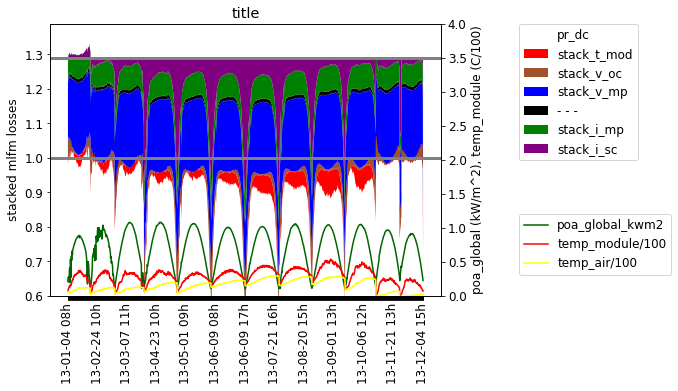

In [57]:
# plot stack loss vs. time (or measurement) chart
fig_stack = plot_mlfm_stack(
    dmeas=meas,
    dnorm=norm,
    dstack=stack,                   # dataframe measurements
    fill_factor=ref['ff'], # ref=ref,                        # dataframe reference STC
    title='title', #
    # mlfm_file_name=mlfm_meas_file,  # name of data file
    # qty_mlfm_vars=qty_mlfm_vars,    # number of mlfm measurements usually 4 or 6
    xaxis_labels=12,                # show this many x_labels or 0 to show all
    is_i_sc_self_ref=False,         # is isc self referenced?
    is_v_oc_temp_module_corr=True,  # is voc temperature corrected?
)


## 17) Fit mechanistic model to measured weather and normalised losses  

Perform a Mechanistic Performance Model (MPM) fit to the mlfm parameters  
poa_global (kW/m$^2$), temp_module (C), wind_speed (ms$^-$$^1$).  

MPM_6 = c_1 + c_2 * (temp_module-25) + c_3 * log10(poa_global_kwm2) +   
        c_4 * poa_global_kwm2 + c_5 * wind_speed + c_6 / poa_global_kwm2  


Report the fit (coeffs) and error (errs) coefficients.   

In [58]:
norm.head()

,pr_dc,pr_dc_temp_corr,i_sc,i_mp,v_oc,v_mp,v_oc_temp_corr,poa_global_bin,temp_module_bin
date_time,,,,,,,,,
2013-01-04 08:15:12-06:00,1.044714,0.977723,0.987068,0.956821,0.999361,0.858525,0.950057,200.0,5.0
2013-01-04 08:20:12-06:00,1.049437,0.989055,0.996282,0.954162,0.999665,0.856551,0.955411,200.0,10.0
2013-01-04 08:25:12-06:00,1.052938,0.999289,1.002413,0.952745,1.000038,0.855104,0.960835,300.0,10.0
2013-01-04 08:30:12-06:00,1.045790,0.993954,1.008897,0.951868,0.987090,0.855696,0.949448,200.0,10.0
2013-01-04 08:35:12-06:00,1.042834,0.991145,1.007930,0.950601,0.986522,0.855729,0.948901,200.0,10.0


In [59]:
# choose which no0rmalised mlfm parameter to model e.g. pr_dc or i_sc..v_oc  
mlfm_sel = 'pr_dc' 

# add selected variable to measured data frame. We do this to ensure that data indexes match.
meas_temp = meas.copy()
meas_temp[mlfm_sel] = norm[mlfm_sel]

cc, coeffs, ee, errs = mlfm_fit(meas_temp, mlfm_sel) # qty_mlfm_vars)##SR## norm

norm['calc_' + mlfm_sel] = cc 

norm['diff_' + mlfm_sel] = norm[mlfm_sel] - norm['calc_' + mlfm_sel] 

norm.describe()

,pr_dc,pr_dc_temp_corr,i_sc,i_mp,v_oc,v_mp,v_oc_temp_corr,poa_global_bin,temp_module_bin,calc_pr_dc,diff_pr_dc
count,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1433.000000,1.433000e+03
mean,0.925018,0.937176,0.941841,0.941404,0.970376,0.833504,0.980062,688.346127,28.872994,0.925018,5.139703e-07
std,0.083688,0.085308,0.075453,0.005757,0.024785,0.013827,0.023198,284.068826,10.603470,0.068291,4.837319e-02
min,0.528479,0.538920,0.598801,0.876107,0.874223,0.806993,0.887511,100.000000,-5.000000,0.605121,-1.878487e-01
25%,0.902565,0.941202,0.942242,0.937743,0.952403,0.821747,0.971589,500.000000,20.000000,0.900437,-1.645589e-02
50%,0.931579,0.963351,0.965174,0.940562,0.972730,0.831606,0.989182,800.000000,30.000000,0.939209,-2.623649e-03
75%,0.980269,0.983274,0.983606,0.944907,0.987761,0.845130,0.996239,900.000000,35.000000,0.966229,1.748713e-02
max,1.085821,1.033045,1.033932,0.961908,1.026911,0.897088,1.006732,1100.000000,55.000000,1.038368,2.907101e-01


## 18) Show residual fit vs. measured for MLFM parameter  

In [60]:
def plot_fit(dmeas, dnorm, fit, title):
    
    ''' 
    Scatter plot fit to normalised measured

    Parameters
    ----------  
    dmeas : dataframe
        measurements, must include 'poa_global_kwm2'
    
    dnorm : dataframe
        normalised multiplicative lfm loss values 'i_sc' .. 'v_oc'
        where pr_dc = 1/ff * product('i_sc', ... 'v_oc').
        
    fit : string
        name of fitted variable e.g. 'pr_dc'.
        
    title : string
        title for graph e.g. mlfm_meas_file.
    '''
    
    fig, ax1 = plt.subplots()

    plt.title(title)

    plt.ylabel('fit ' + fit + ' * poa_global_kwm2')
    ax1.set_ylim(0, 1.2)

    plt.xlabel('meas ' + fit + '* poa_global_kwm2')
    ax1.set_xlim(0, 1.2)

    plt.plot(
        dnorm[fit] * dmeas['poa_global_kwm2'],
        dnorm['calc_' + fit] * dmeas['poa_global_kwm2'], ##SR##
        'c^',
        label = fit
    )

    # plot 1:1 line to show optimum fit
    plt.plot((0,1.2),(0,1.2), 'ko-')

    plt.legend(loc='upper left')
    plt.show()

## Fig 6 : fit_mlfm_sel * poa_global vs. measured_mlfm_sel * poa_global

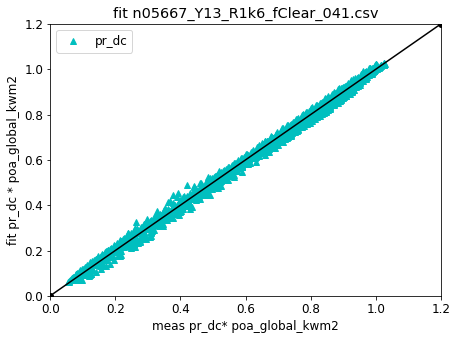

In [61]:
# plot fit vs. measured, include a 1:1 line for comparison
fit_plot = plot_fit(meas, norm, mlfm_sel, 'fit ' + mlfm_meas_file)

## 19) Plot heatmap of mean residual vs. tenp_module and poa_global

Show a heatmap of the average residual (meas - fit) error  
for each irradiance (100W/m^2)  and tmod bin (5C).

In [62]:
def plot_heatmap(dmeas, dnorm, fit, y_axis, x_axis, z_axis, title):
    '''
    Plot a heatmap of Z vs. binned X and Y axes.

    Parameters
    ----------
    dmeas : dataframe
        measured weather data
        'poa_global', 'temp_module', 'wind_speed'
        and measured electrical/thermal values
        'i_sc' .. 'v_oc', temp_module.

    dnorm : dataframe
        normalised multiplicative lfm loss values 'i_sc' .. 'v_oc'
        where pr_dc = 1/ff * product('i_sc', ... 'v_oc').

    fit : string
        fitted parameter e.g. 'pr_dc'.

    x_axis : string
        binned x axis e.g. 'poa_global_bin'.

    y_axis : string
        binned y axis e.g. 'temp_module_bin'.

    z_axis : string
        value as a colour surface plot e.f. 'diff_pr_dc'.

    title : string
        title for graph e.g. mlfm_meas_file.

    '''

    df_piv = pd.pivot_table(
        dnorm,
        index=y_axis,       # e.g. 'temp_module_bin'
        columns=x_axis,     # e.g. 'poa_global_bin'
        values=z_axis,      # value to aggregate
        fill_value=0,       # fill empty cells with this ?
        aggfunc=[np.mean],  # e.g. min, np.sum, len->count
        margins=False,      # grand totals hide
        dropna=True         # hide missing rows or columns
    )

    fig, ax1 = plt.subplots()

    # force z limits to be -2% to +2% if desired
    df_piv = df_piv.clip(lower = -0.02, upper = +0.02)

    im = ax1.imshow(
        df_piv,
        cmap='RdYlBu',
        origin='lower'
    )

    cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.75, label=z_axis)

    #Y AXIS : show only 1 of each y_skip labels
    y_ticks = df_piv.shape[0]
    plt.yticks(np.arange(0, y_ticks), rotation=0)
    yax2 = [''] * y_ticks
    y_skip = 2
    y_count = 0
    while y_count < y_ticks:
        if y_count % y_skip == 0:
            yax2[y_count] = df_piv.index[y_count]
        y_count += 1

    ax1.set_yticklabels(yax2)
    ax1.set_ylabel(y_axis)

    # X AXIS : show only 1 of each x_skip labels
    x_ticks = df_piv.shape[1]
    plt.xticks(np.arange(0, x_ticks), rotation=90)

    xax2 = [''] * x_ticks
    x_skip = 2
    x_count = 0
    while x_count < x_ticks:
        if x_count % x_skip == 0:
            xax2[x_count] = df_piv.columns.levels[1][x_count]
        x_count += 1
        
    ax1.set_title(title)

    ax1.set_xticklabels(xax2)
    ax1.set_xlabel(x_axis)

    ax1.grid( color='k', linestyle=':', linewidth=1)

### 20) Residual MLFM fit heatmap vs. poa_global and temp_module. Fig 7 

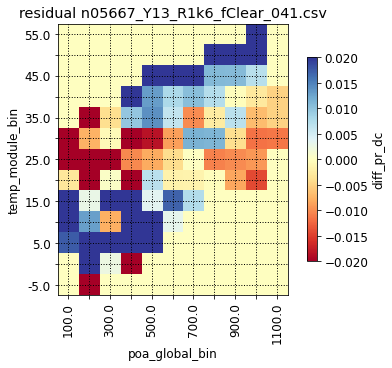

In [63]:
# plot heatmap
heatmap_plot = plot_heatmap(
    dnorm=norm,
    dmeas=meas,
    fit=mlfm_sel,
    y_axis='temp_module_bin',
    x_axis='poa_global_bin',
    z_axis='diff_' + mlfm_sel,
    title='residual ' + mlfm_meas_file
)

## 21) Read in complete (G,T) Matrix to fill with MLFM predicted values  

Read in a matrix with complete values of   
Irradiance (G=100,200 .. 1100,1200) and module temperature (T=0,5 .. 65,70)  
to predict all MPM values 

In [64]:
# read in the complete matrix data
matr = pd.read_csv(root_dir + '\\mlfm_data\\ref\\mlfm_matrix.csv', index_col = 'id')

matr['poa_global_kwm2'] = matr['poa_global'] / 1000

matr

#matr['poa_global'] = matr['poa_global'] /1000

,mid,poa_global,temp_module,wind_speed,poa_global_kwm2
id,,,,,
1,matrix,100,0,0,0.1
2,matrix,100,5,0,0.1
3,matrix,100,10,0,0.1
4,matrix,100,15,0,0.1
5,matrix,100,20,0,0.1
...,...,...,...,...,...
176,matrix,1200,50,0,1.2
177,matrix,1200,55,0,1.2
178,matrix,1200,60,0,1.2


## 22) Predict performance from MPM fit coefficients   

1. generate predicted mpm data  
2. create a pivot table mpm(g,t)  
3. show as a heat map

In [65]:
# show model coefficients
coeffs

array([ 1.27322965e+00, -4.79822729e-03,  6.18579737e-01, -2.83381845e-01,
       -4.16977322e-01, -1.74639665e-09])

In [66]:
# populate pivot table from predicted mpm data
matr[mlfm_sel] = mlfm_6(matr, coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5])

#matr[mlfm_sel] = mlfm_6(matr, coeffs)

matr

,mid,poa_global,temp_module,wind_speed,poa_global_kwm2,pr_dc
id,,,,,,
1,matrix,100,0,0,0.1,0.746267
2,matrix,100,5,0,0.1,0.722276
3,matrix,100,10,0,0.1,0.698285
4,matrix,100,15,0,0.1,0.674294
5,matrix,100,20,0,0.1,0.650303
...,...,...,...,...,...,...
176,matrix,1200,50,0,1.2,0.862196
177,matrix,1200,55,0,1.2,0.838205
178,matrix,1200,60,0,1.2,0.814213


## 23) Plot heatmap of predicted MLFM values vs. temp_mod and poa_global bins

In [67]:
def plot_contourf(df, x_axis, y_axis, z_axis, title,
                  vmin=0, vmax=1.2, levels=5):
    ''' 
    Plot filled contour plot Z vs. X and Y bins.

    Parameters
    ----------
    df : dataframe
        measured or noralised data containing weather columns
        (poa_global, temp_module and wind_speed).

    x_axis : string
        binned x axis e.g. 'poa_global'.

    y_axis : string
        binned y axis e.g. 'temp_module'.

    z_axis : string
        measured value as a colour surface plot.

    title : string
        title for graph e.g. mlfm_meas_file.

    vmin, vmax : float
        minimum and maximum values for contour chart ###

    '''  
   
    piv = pd.pivot_table(
        df,
        index=y_axis,
        columns=x_axis,
        values=z_axis,
        fill_value=0,      # fill empty cells?
        aggfunc=[np.mean], # min, np.sum, len->count
        margins=False,     # grand totals
        dropna=True        # hide missing rows or columns
    )

    piv = piv.clip(vmin, vmax)

    fig, ax1 = plt.subplots()

    cs = plt.contourf(
        piv,
        cmap='RdYlBu',  # or 'nipy_spectral',
      # origin='lower'
      # nchunkint=1,
        levels=levels,
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(cs, ax=ax1)
    cbar.ax.set_ylabel(z_axis,
                       rotation=90,
                       va='bottom',
                       labelpad=+30)

    plt.title(title)

    y_ticks = piv.shape[0]
    plt.yticks(np.arange(0, y_ticks), rotation=0)

    # show only 1 of each y_skip labels
    yax2 = [''] * y_ticks
    y_skip = 2
    y_count = 0
    while y_count < y_ticks:
        if y_count % y_skip == 0:
            yax2[y_count] = piv.index[y_count]
        y_count += 1

    ax1.set_yticklabels(yax2)
    ax1.set_ylabel(y_axis)

    x_ticks = piv.shape[1]
    plt.xticks(np.arange(0, x_ticks), rotation=90)

    # show only 1 of each x_skip labels
    xax2 = [''] * x_ticks
    x_skip = 2
    x_count = 0
    while x_count < x_ticks:
        if x_count % x_skip == 0:
            xax2[x_count] = piv.columns.levels[1][x_count]
        x_count += 1

    ax1.set_xticklabels(xax2)
    ax1.set_xlabel(x_axis)

    ax1.grid( color='k', linestyle=':', linewidth=1)

In [68]:
# REMOVE LOW TEMPERATURE DATA WHICH MAY CONTAIN SNOW

matr2 = matr[matr['temp_module'] >= 10]

matr2

,mid,poa_global,temp_module,wind_speed,poa_global_kwm2,pr_dc
id,,,,,,
3,matrix,100,10,0,0.1,0.698285
4,matrix,100,15,0,0.1,0.674294
5,matrix,100,20,0,0.1,0.650303
6,matrix,100,25,0,0.1,0.626312
7,matrix,100,30,0,0.1,0.602321
...,...,...,...,...,...,...
176,matrix,1200,50,0,1.2,0.862196
177,matrix,1200,55,0,1.2,0.838205
178,matrix,1200,60,0,1.2,0.814213


### 24) Contour plot of predicted mlfm_sel + vs. poa_global and temp_mod. 

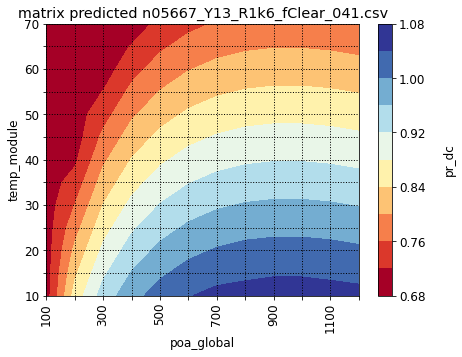

In [69]:
contour_plot = plot_contourf(
    df=matr2,
    y_axis='temp_module',
    x_axis='poa_global',
    z_axis=mlfm_sel,
    title='matrix predicted ' + mlfm_meas_file,
    vmin=0.7,
    vmax=1.05,
    levels=9
)

### 25) Contour plot of measured mlfm_sel  vs. poa_global and temp_mod. Fig 9

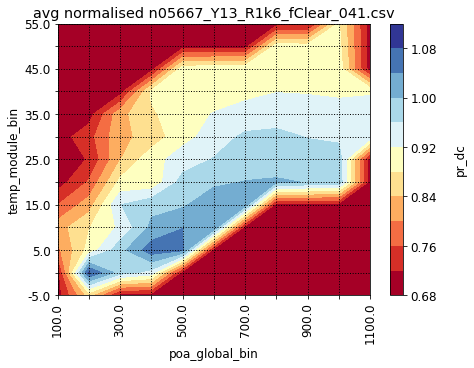

In [70]:
contour_plot = plot_contourf(
    df=norm,
    y_axis='temp_module_bin',
    x_axis='poa_global_bin',
    z_axis=mlfm_sel,
    title='avg normalised ' + mlfm_meas_file,
    vmin=0.7,
    vmax=1.1,
    levels=9
)

## 26) References  
     
The Loss Factors Model (LFM) and Mechanistic Performance Model (MPM)  
together known as "MLFM" have been developed by SRCL and Gantner Instruments  
(previously Oerlikon Solar and Tel Solar) since 2011 MLFM and 2017 MPM  
  
.. [1] J. Sutterlueti(now Gantner Instruments) and  S. Ransome  
 '4AV.2.41 Characterising PV Modules under Outdoor Conditions:  
What's Most Important for Energy Yield'  
26th EU PVSEC 8 September 2011; Hamburg, Germany  
http://www.steveransome.com/pubs/2011Hamburg_4AV2_41.pdf  

.. [2] Steve Ransome and Juergen Sutterlueti(Gantner Instruments)  
  'Choosing the best Empirical Model for predicting energy yield'   
  7th PV Energy Rating and Module Performance Modeling Workshop,  
  Canobbio, Switzerland 30-31 March, 2017  

.. [3] S. Ransome and J. Sutterlueti (Gantner Instruments)  
'Checking the new IEC 61853.1-4 with high quality 3rd party data to  
benchmark its practical relevance in energy yield prediction'  
PVSC June 2019 Chicago, USA  
http://www.steveransome.com/PUBS/1906_PVSC46_Chicago_Ransome.pdf

.. [4] Steve Ransome (SRCL) and Juergen Sutterlueti (Gantner Instruments)  
'5CV.4.35 Quantifying Long Term PV Performance and Degradation  
under Real Outdoor and IEC 61853 Test Conditions  
Using High Quality Module IV Measurements'   
36th EU PVSEC Sep 2019  
http://www.steveransome.com/PUBS/1909_5CV4_35_PVSEC36_Marseille_Ransome_PPT.pdf

.. [5] Steve Ransome (SRCL)  
'How to use the Loss Factors and Mechanistic Performance Models  
effectively with PVPMC/PVLIB'   
PVPMC Webinar on PV Performance Modeling Methods, Aug 2020  
https://pvpmc.sandia.gov/download/7879/  

.. [6] W.Marion et al (NREL)  
'New Data Set for Validating PV Module Performance Models'  
https://www.researchgate.net/publication/286746041_New_data_set_for_validating_PV_module_performance_models  
https://www.nrel.gov/docs/fy14osti/61610.pdf

Many more papers are available at www.steveransome.com  
